<a href="https://colab.research.google.com/github/hhnguyen-20/SoDA-Social-Distancing-Alert-with-Smartwatches/blob/main/SoDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Import

## Download the dataset
- Create a new folder named "project_soda" in Google Drive
- Download the [SoDA dataset](https://www.kaggle.com/datasets/rabieelkharoua/soda-social-distancing-alert-with-smartwatches)
- Unzip the above dataset and only upload its data source to the new folder

## Library Import
- Import essential Python libraries for data manipulation and machine learning (e.g., NumPy, Pandas, Matplotlib, Scikit-learn)

In [1]:
import scipy.io
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, GRU, Bidirectional
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import plotly.graph_objects as go
from tensorflow.keras.utils import to_categorical

## Data Loading
- Load the dataset from a specified location into a Pandas DataFrame for efficient data Handling

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Change directory to the dataset location
dataset_path = '/content/drive/My Drive/project_soda/datasource/'
os.chdir(dataset_path)

Mounted at /content/drive


In [3]:
# List .mat files in the dataset directory
mat_files = [file for file in os.listdir() if file.endswith('.mat')]
print(f"Found {len(mat_files)} .mat files")
print(f"Files in dataset directory: {mat_files}")

Found 1800 .mat files
Files in dataset directory: ['06_15_9.mat', '02_17_8.mat', '02_9_4.mat', '04_1_6.mat', '06_18_9.mat', '01_8_7.mat', '01_15_6.mat', '02_5_7.mat', '04_16_6.mat', '01_6_1.mat', '06_15_6.mat', '05_10_7.mat', '03_11_0.mat', '05_6_9.mat', '06_14_1.mat', '04_17_2.mat', '03_17_2.mat', '04_8_9.mat', '03_14_4.mat', '04_10_7.mat', '05_6_1.mat', '03_7_8.mat', '05_4_3.mat', '06_1_2.mat', '01_18_6.mat', '01_9_0.mat', '04_17_8.mat', '05_7_1.mat', '05_13_3.mat', '03_4_3.mat', '06_12_4.mat', '04_5_2.mat', '03_7_0.mat', '02_4_1.mat', '03_12_1.mat', '02_8_7.mat', '05_8_4.mat', '02_5_9.mat', '06_12_6.mat', '05_5_0.mat', '05_16_6.mat', '03_15_5.mat', '04_15_7.mat', '02_11_5.mat', '01_15_4.mat', '05_12_2.mat', '01_3_1.mat', '01_2_8.mat', '05_13_4.mat', '06_16_6.mat', '06_15_1.mat', '02_7_5.mat', '04_14_9.mat', '04_7_3.mat', '06_17_9.mat', '03_7_7.mat', '05_10_0.mat', '03_5_7.mat', '02_17_0.mat', '03_12_0.mat', '01_5_6.mat', '02_8_3.mat', '05_9_6.mat', '03_1_7.mat', '05_11_5.mat', '06_1

In [4]:
# Load one example .mat file
eg = scipy.io.loadmat(mat_files[0])

# Display the keys in the .mat file
eg.keys()

dict_keys(['__header__', '__version__', '__globals__', 'accData', 'gyrData', 'label'])

In [5]:
def get_action(n):
    switcher = {
        1: 'one-hand handshake',
        2: 'two-hand handshake',
        3: 'hug',
        4: 'kiss on the hand',
        5: 'bisous/ fact to face',
        6: 'kiss on the forehead',
        7: 'bow',
        8: 'high five',
        9: 'hand in hand',
        10: 'pass on things',
        11: 'walk',
        12: 'run',
        13: 'up the stairs',
        14: 'down the stars',
        15: 'sit down',
        16: 'stand up',
        17: 'drink water',
        18: 'keystroke'
    }
    return switcher.get(n, "NaN")

In [6]:
sub_list = []
act_list = []
acc_list = []
gyr_list = []
label_list = []

for f in mat_files:
    mat_data = scipy.io.loadmat(f)

    name, format = os.path.splitext(f)
    sub, act_n, rep = name.split('_')

    # Extract data
    acc_data = mat_data['accData']
    gyr_data = mat_data['gyrData']
    label = mat_data['label'][0][0]

    # Flatten the sequences and add to the lists
    for i in range(mat_data['label'].shape[1]):
        acc_list.append(acc_data[0, :, i])
        gyr_list.append(gyr_data[0, :, i])
        sub_list.append(int(sub))
        label_list.append(label)
        act_list.append(get_action(label))

In [7]:
# Create a dictionary with the lists
data = {
    'label': label_list,
    'action': act_list
}

# Create DataFrame
sub_df = pd.DataFrame(sub_list, columns=['subject'])
acc_df = pd.DataFrame(acc_list, columns=['acc_x', 'acc_y', 'acc_z'])
gyr_df = pd.DataFrame(gyr_list, columns=['gyr_x', 'gyr_y', 'gyr_z'])
label_df = pd.DataFrame(data)

# Concatenate the DataFrames
df = pd.concat([sub_df, acc_df, gyr_df, label_df], axis=1)

In [8]:
df

subject     acc_x     acc_y     acc_z      gyr_x      gyr_y  \
0             6 -8.544770 -1.801795 -1.191626  22.120001  43.750000   
1             6 -8.183454 -1.741975 -1.423729  29.680000  40.950001   
2             6 -7.862815 -1.978864 -0.899701  31.850000  35.910000   
3             6 -7.278966 -2.471786 -0.200997  10.920000  35.910000   
4             6 -7.121039 -2.285146 -0.177069 -44.590000  45.430000   
...         ...       ...       ...       ...        ...        ...   
321191        1 -8.889337 -4.228118 -2.215754  28.559999   7.770000   
321192        1 -8.908479 -4.237689 -2.258825  28.840000   8.540000   
321193        1 -8.944371 -4.185047 -2.246860  28.210001   9.520000   
321194        1 -8.965906 -4.228118 -2.227718  27.650000  10.640000   
321195        1 -8.977871 -4.230510 -2.237289  27.650000  12.320000   

            gyr_z  label              action  
0       47.040001     15            sit down  
1       46.410000     15            sit down  
2       44.450001     15            sit down  
3       37.380001     15            sit down  
4       23.450001     15            sit down  
...           ...    ...                 ...  
321191  14.000000      1  one-hand handshake  
321192  11.900000      1  one-hand handshake  
321193   8.750000      1  one-hand handshake  
321194   5.320000      1  one-hand handshake  
321195   1.890000      1  one-hand handshake  

[321196 rows x 9 columns]

# Dataset Visualization
- Histograms for each attribute
- Scatter plots to see relationships between attributes
- Pair plots to visualize all pairwise relationships

In [9]:
# Count the occurrences of each action
action_counts = df['action'].value_counts()

# Create the pie chart
fig = px.pie(action_counts, values=action_counts.values, names=action_counts.index, title='Distribution of Actions')

# Display the chart
fig.show()


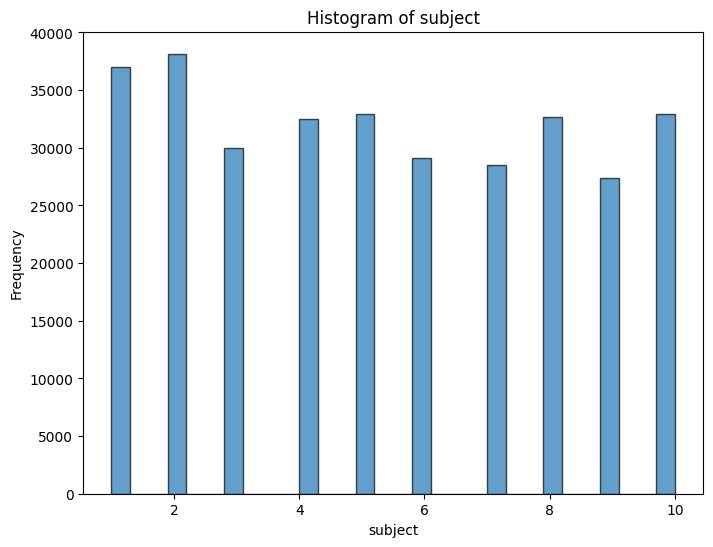

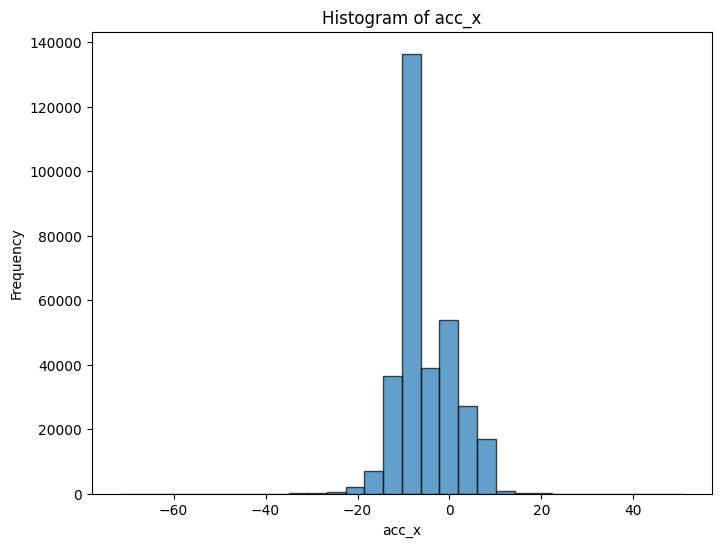

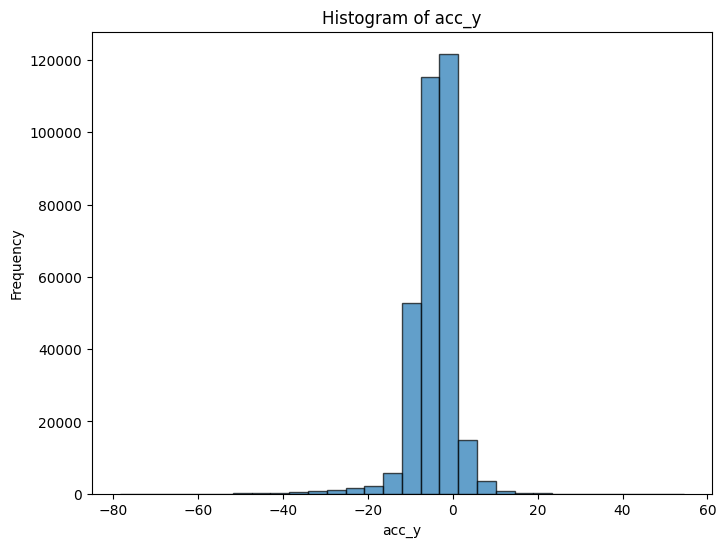

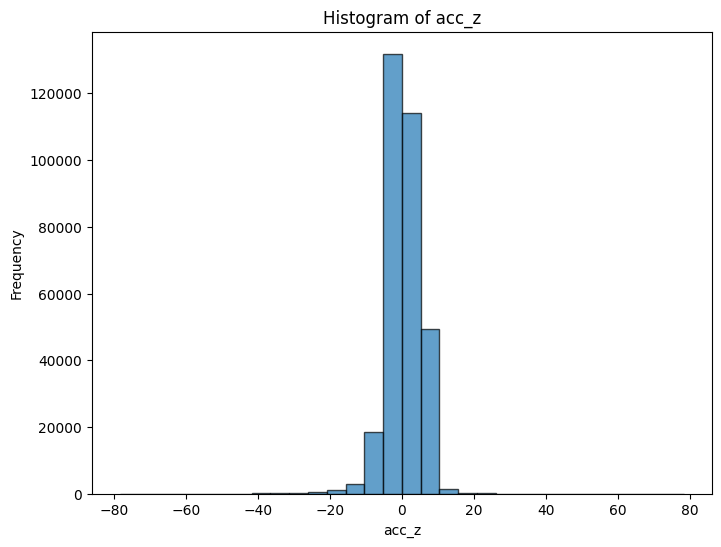

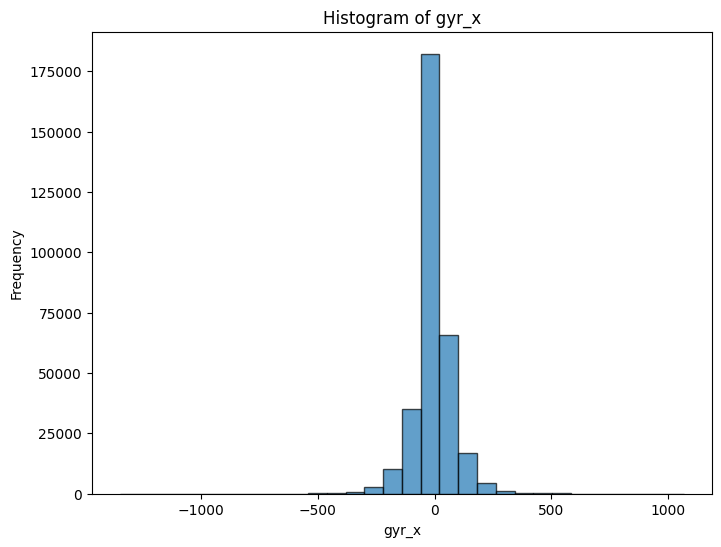

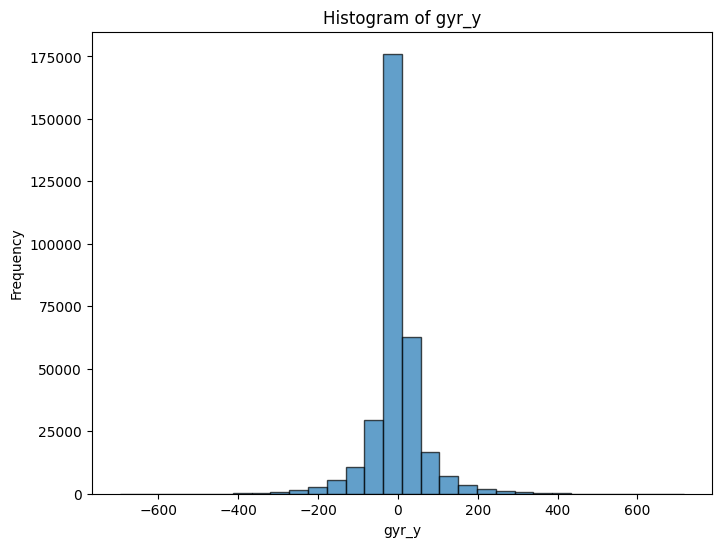

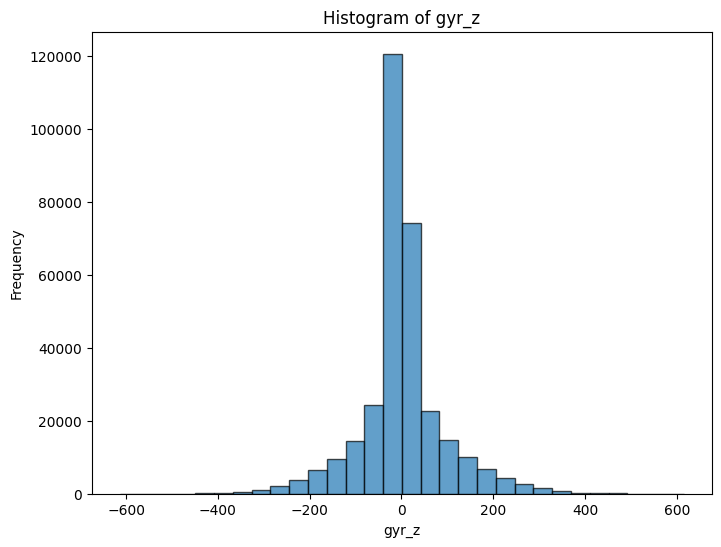

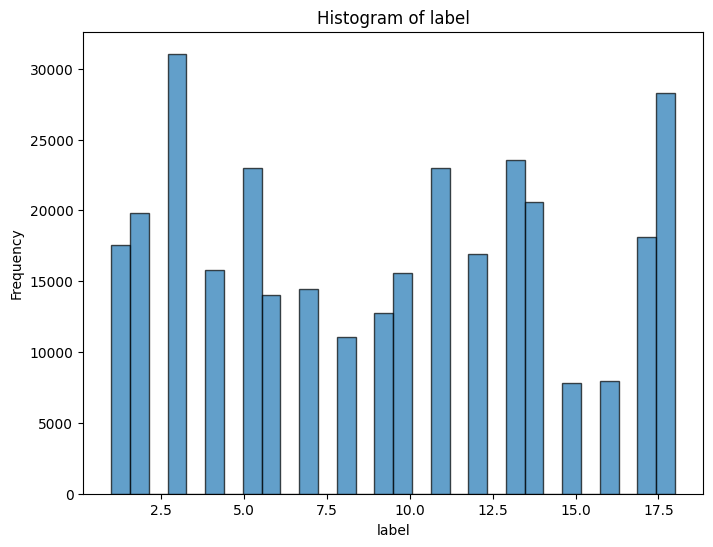

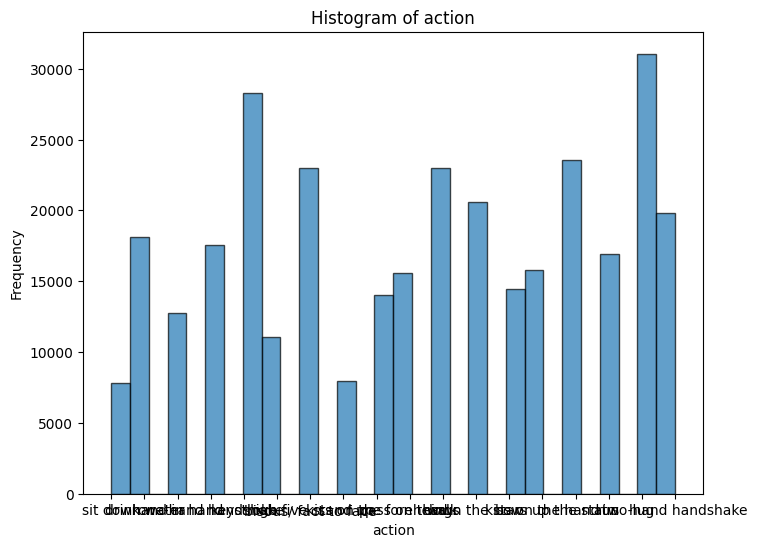

In [10]:
# Create Histograms for Each Attribute
for column in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

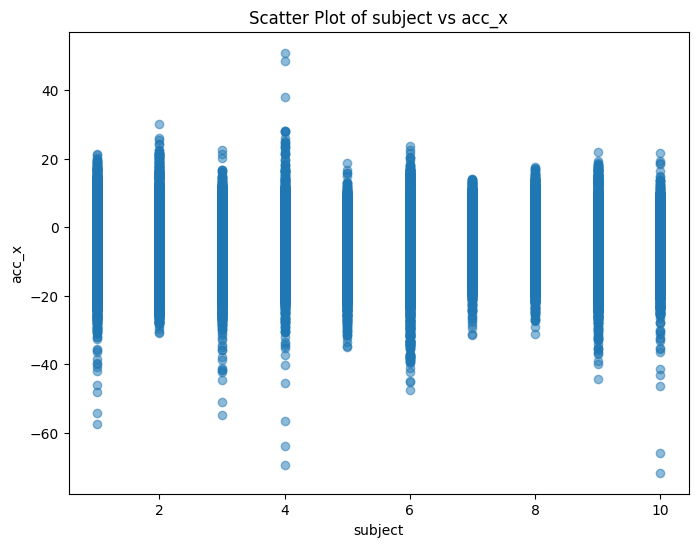

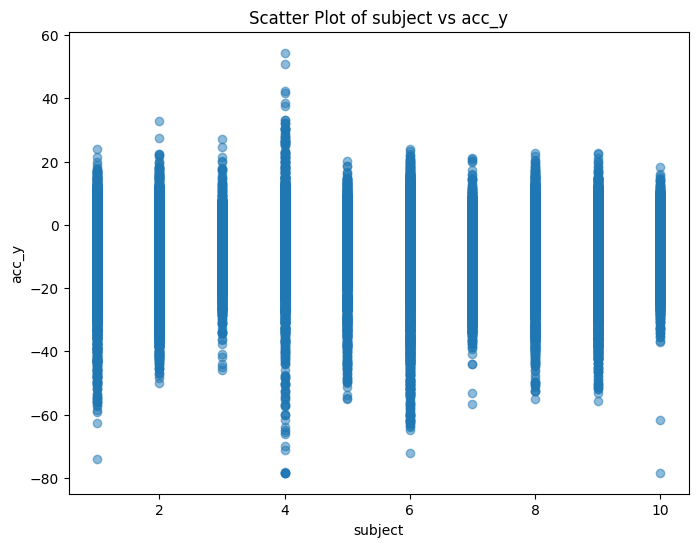

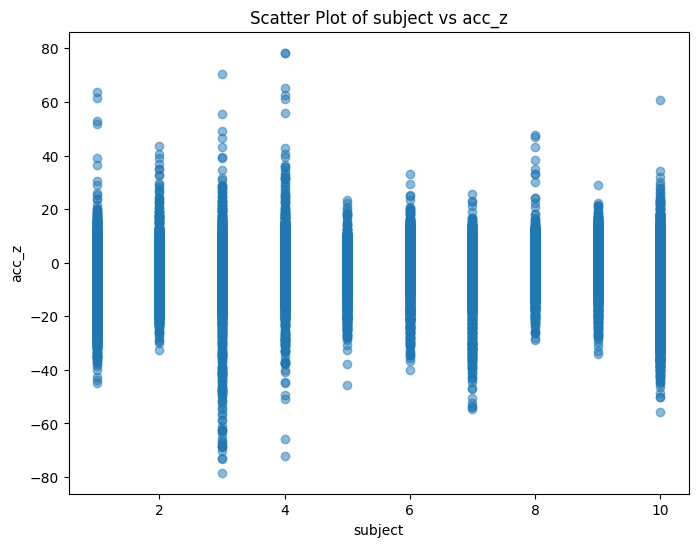

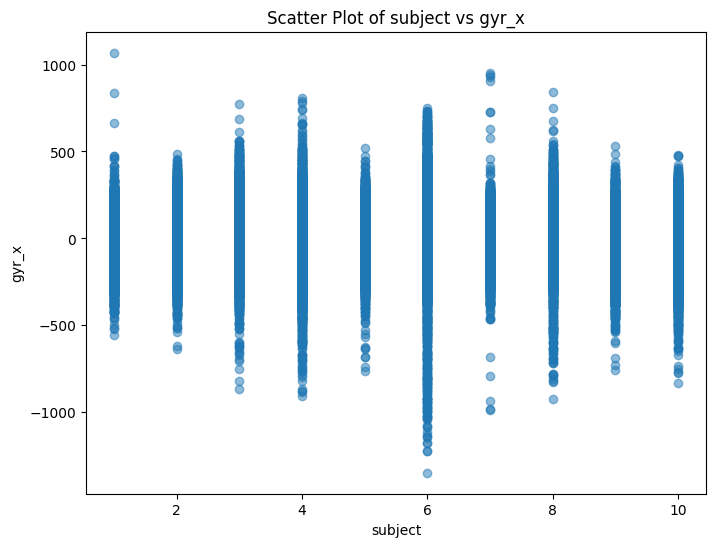

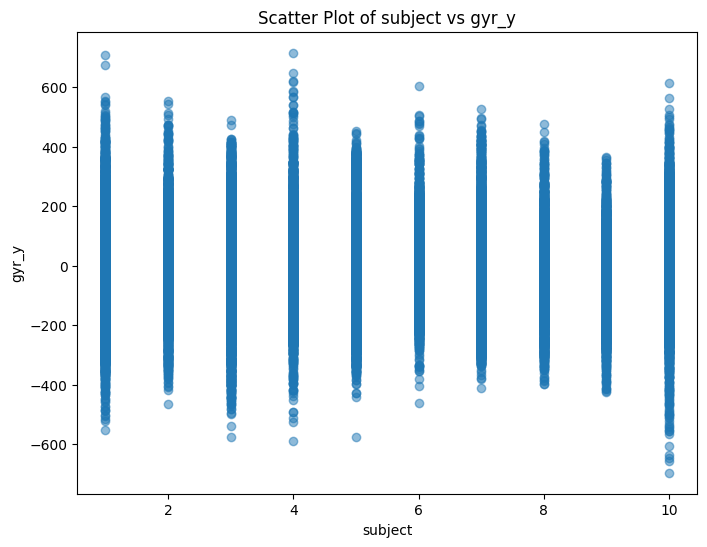

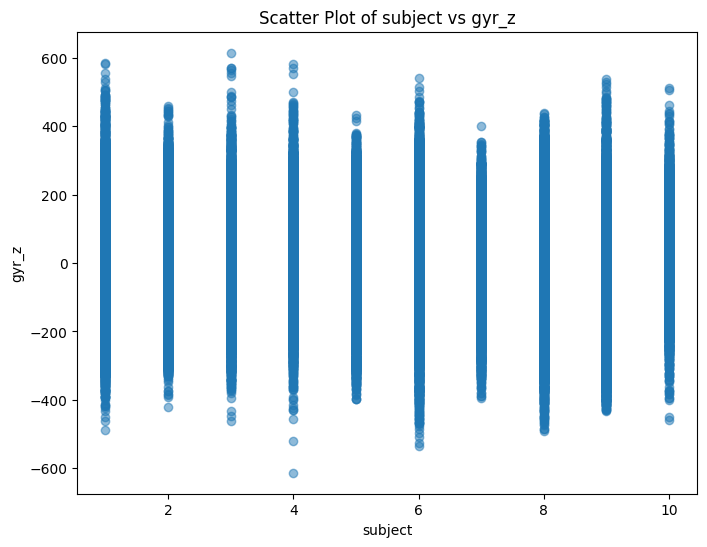

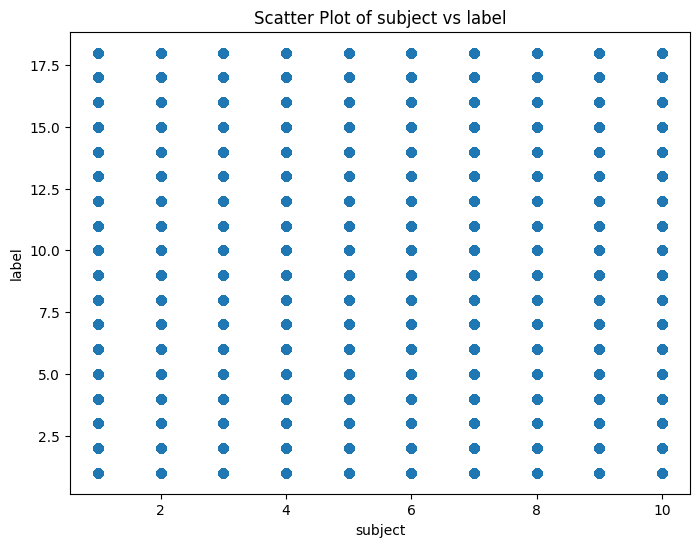

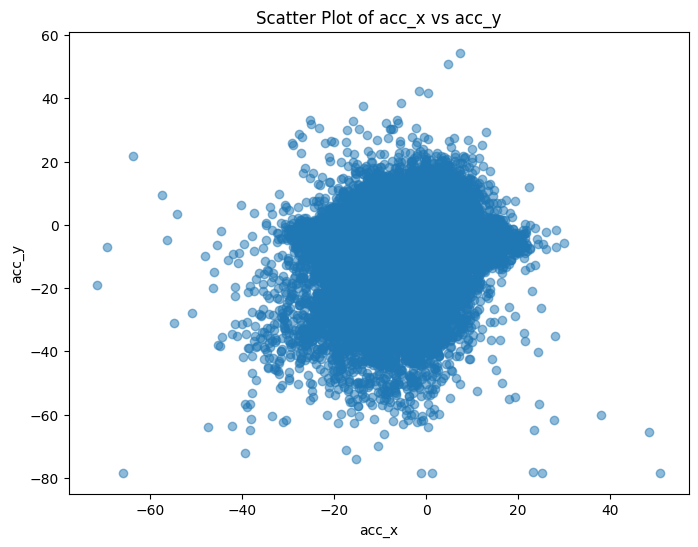

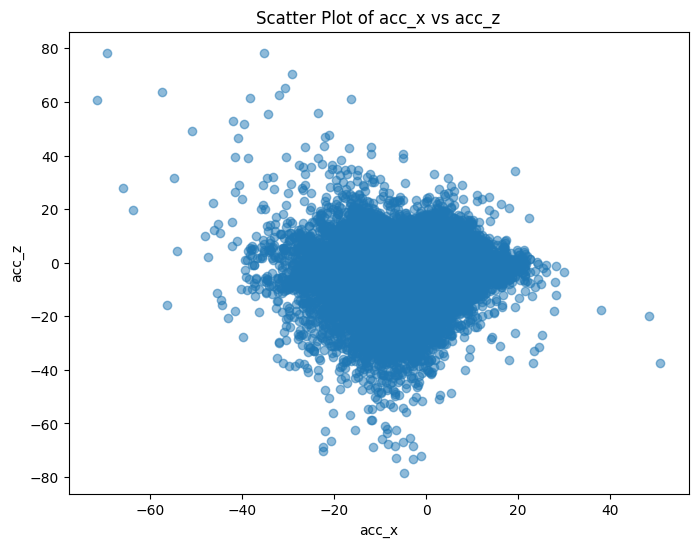

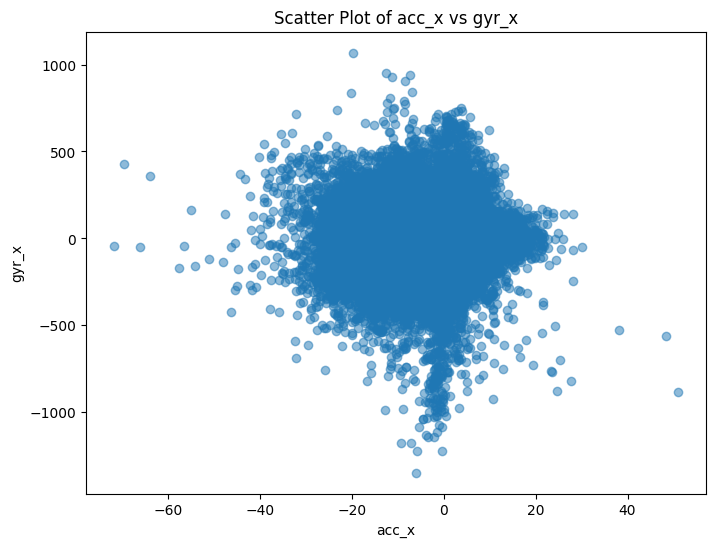

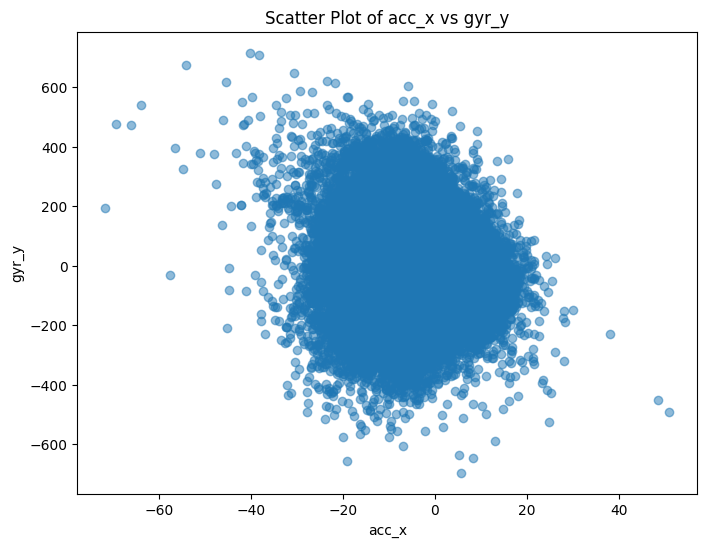

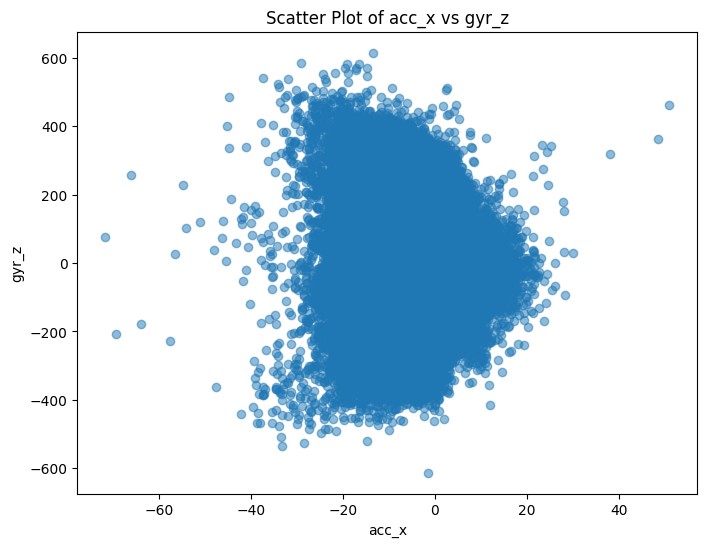

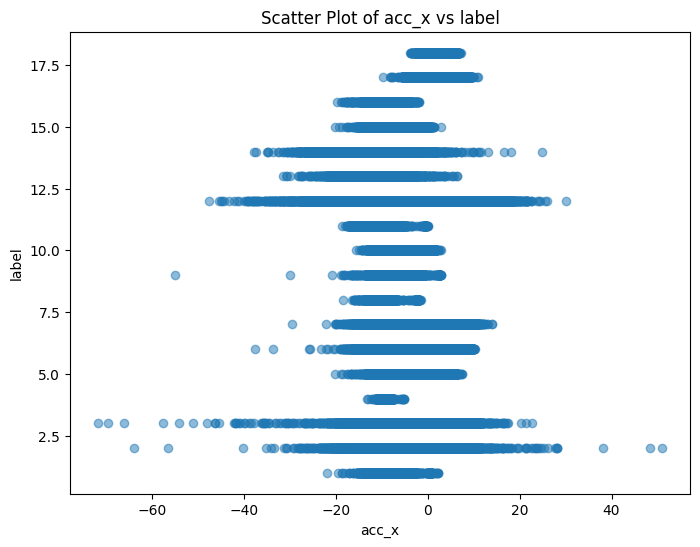

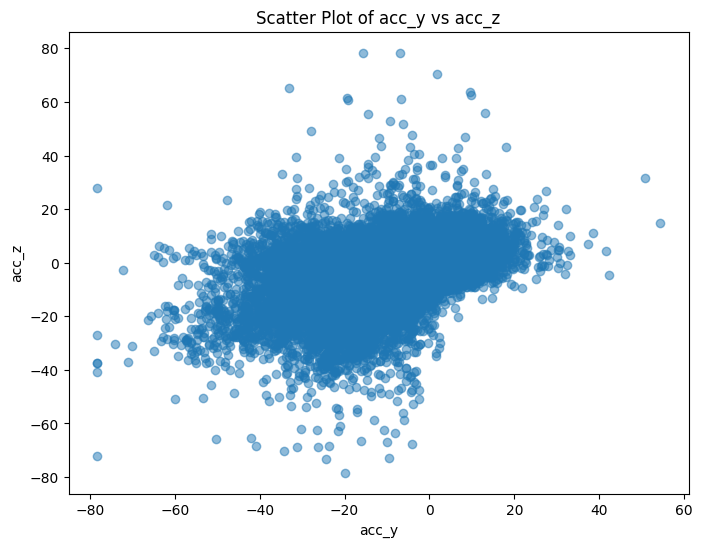

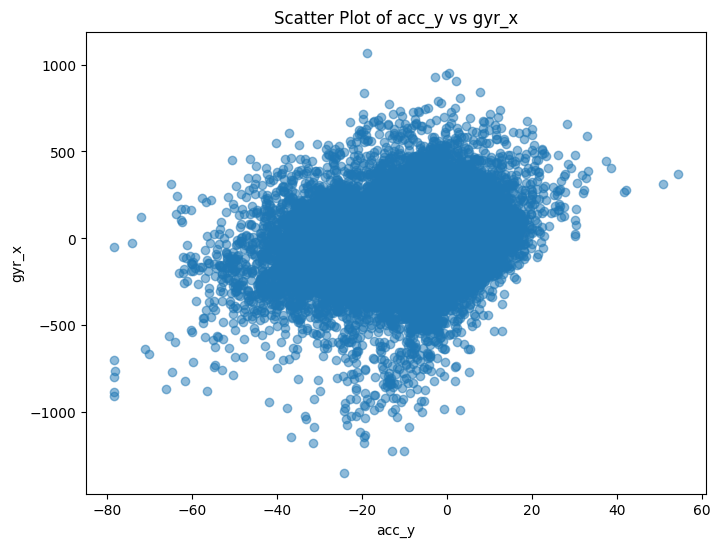

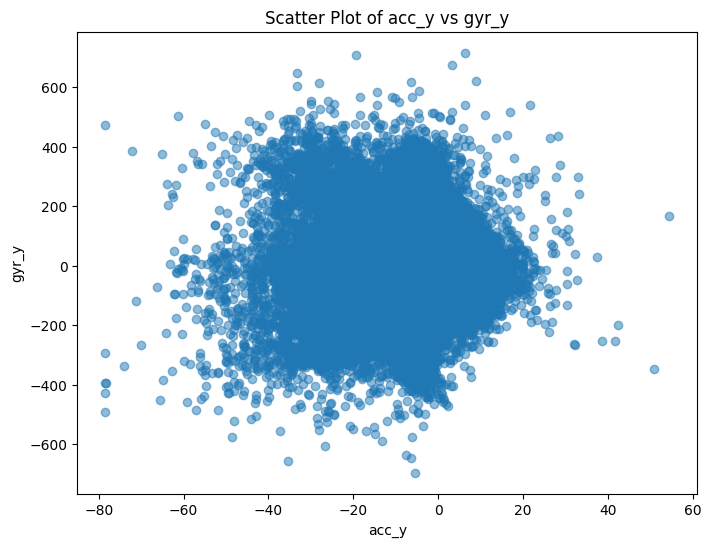

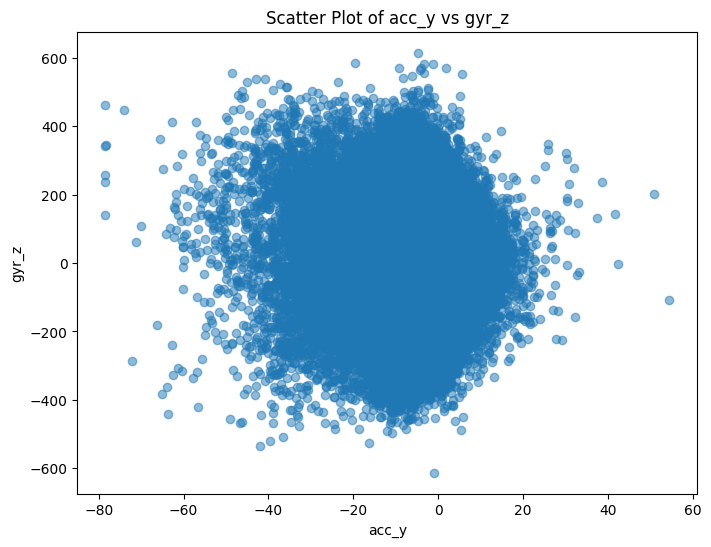

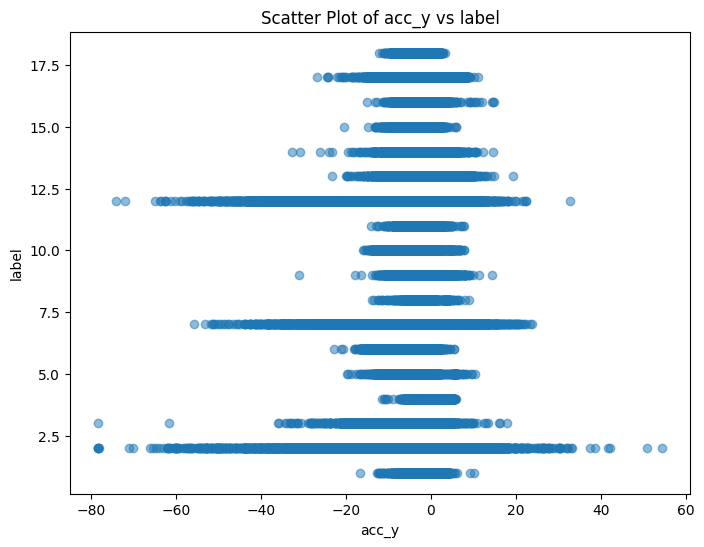

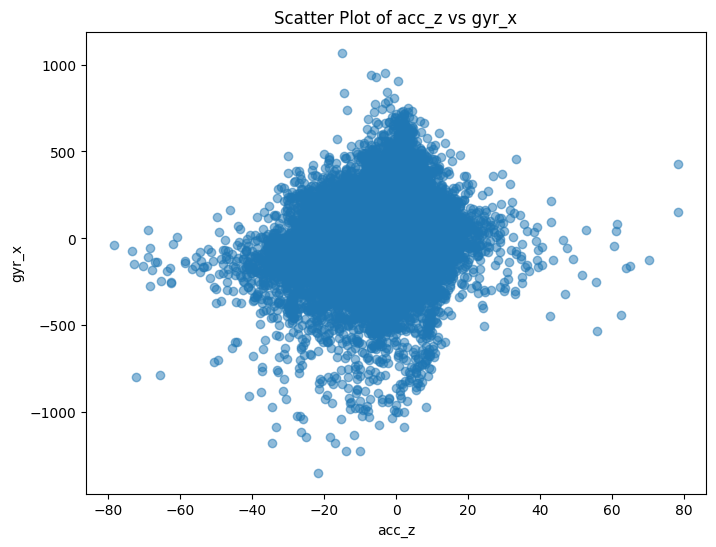

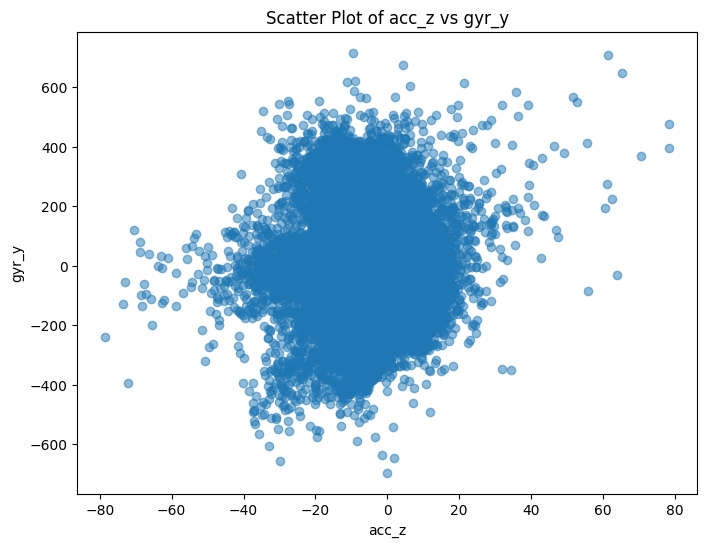

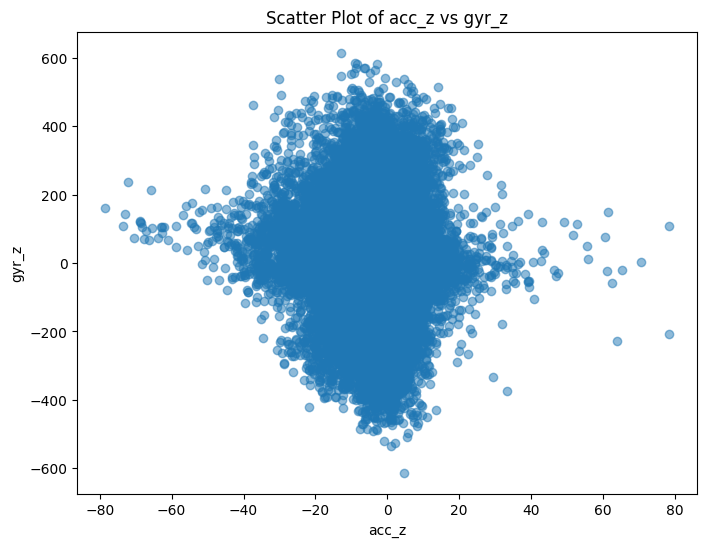

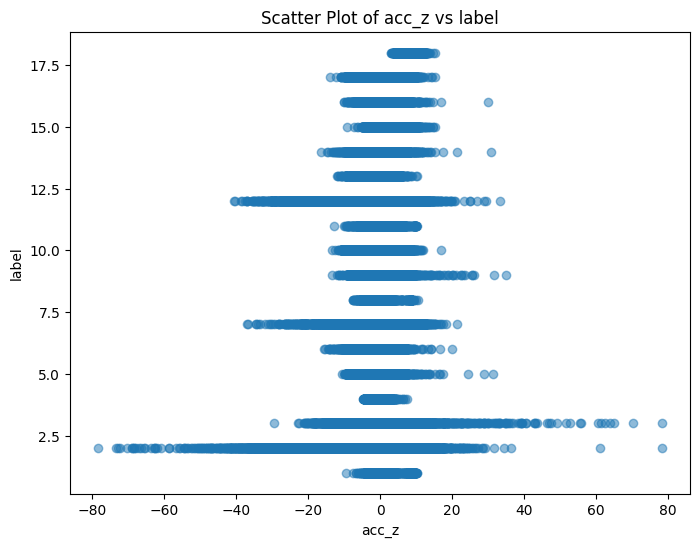

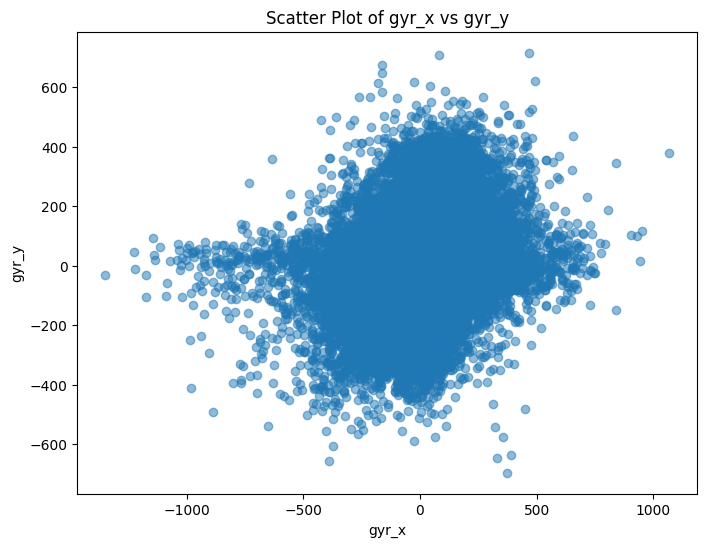

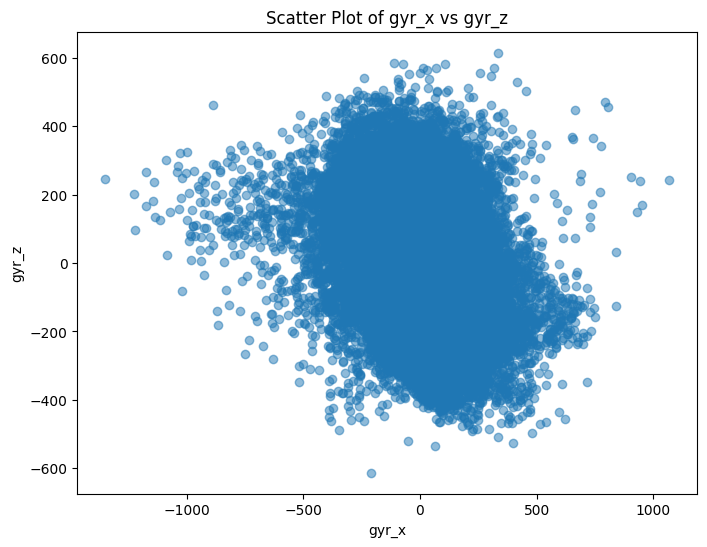

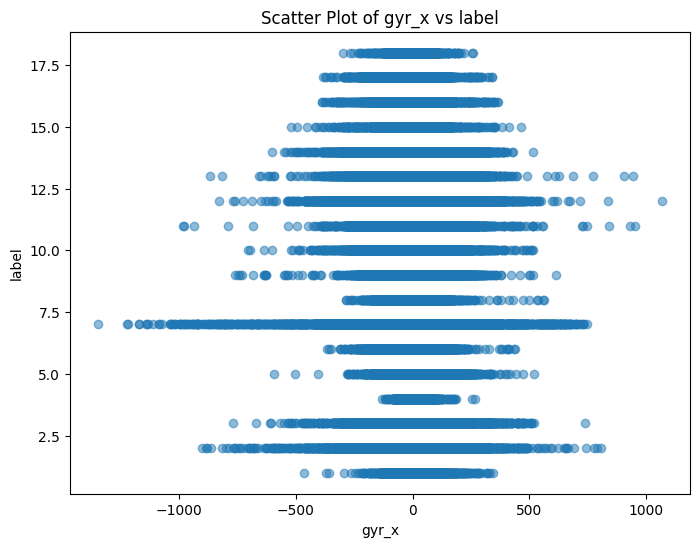

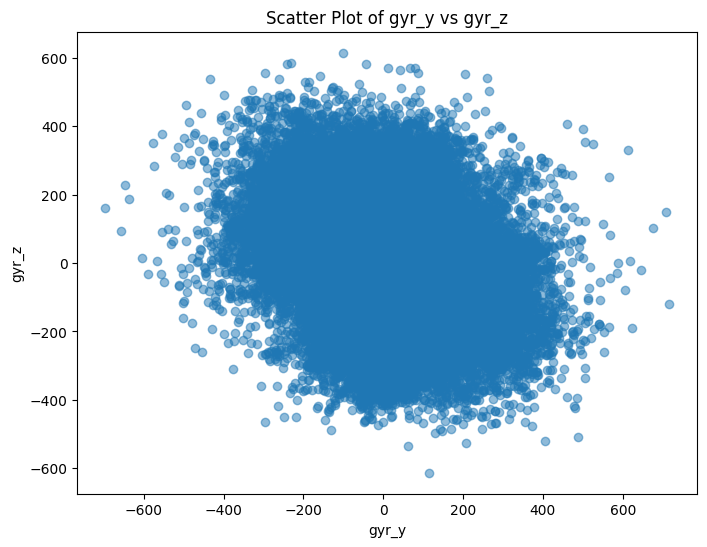

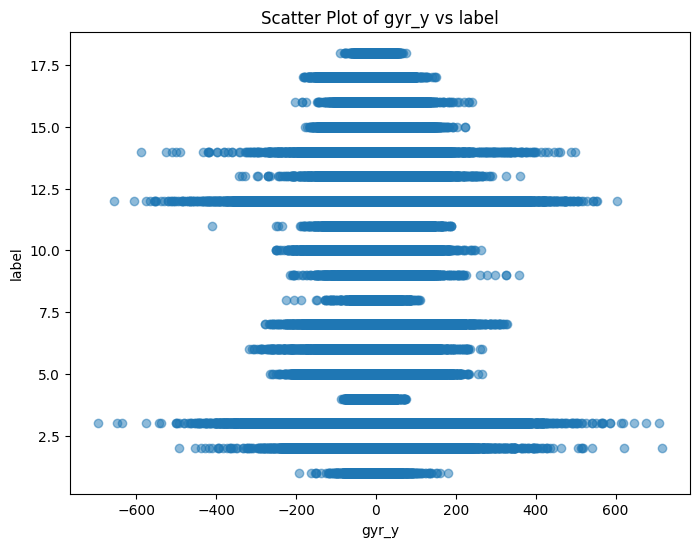

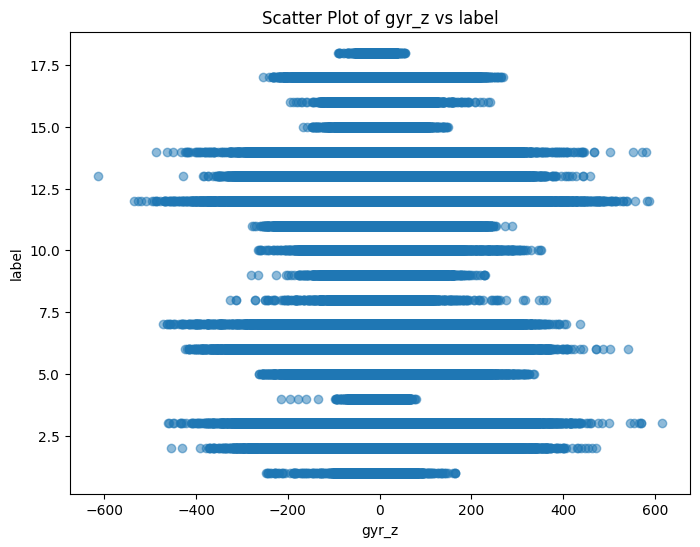

In [11]:
# Create Scatter Plots for Attribute Relationships
numeric_columns = df.select_dtypes(include=['float', 'int']).columns

for i in range(len(numeric_columns)):
    for j in range(i + 1, len(numeric_columns)):
        plt.figure(figsize=(8, 6))
        plt.scatter(df[numeric_columns[i]], df[numeric_columns[j]], alpha=0.5)
        plt.title(f'Scatter Plot of {numeric_columns[i]} vs {numeric_columns[j]}')
        plt.xlabel(numeric_columns[i])
        plt.ylabel(numeric_columns[j])
        plt.show()

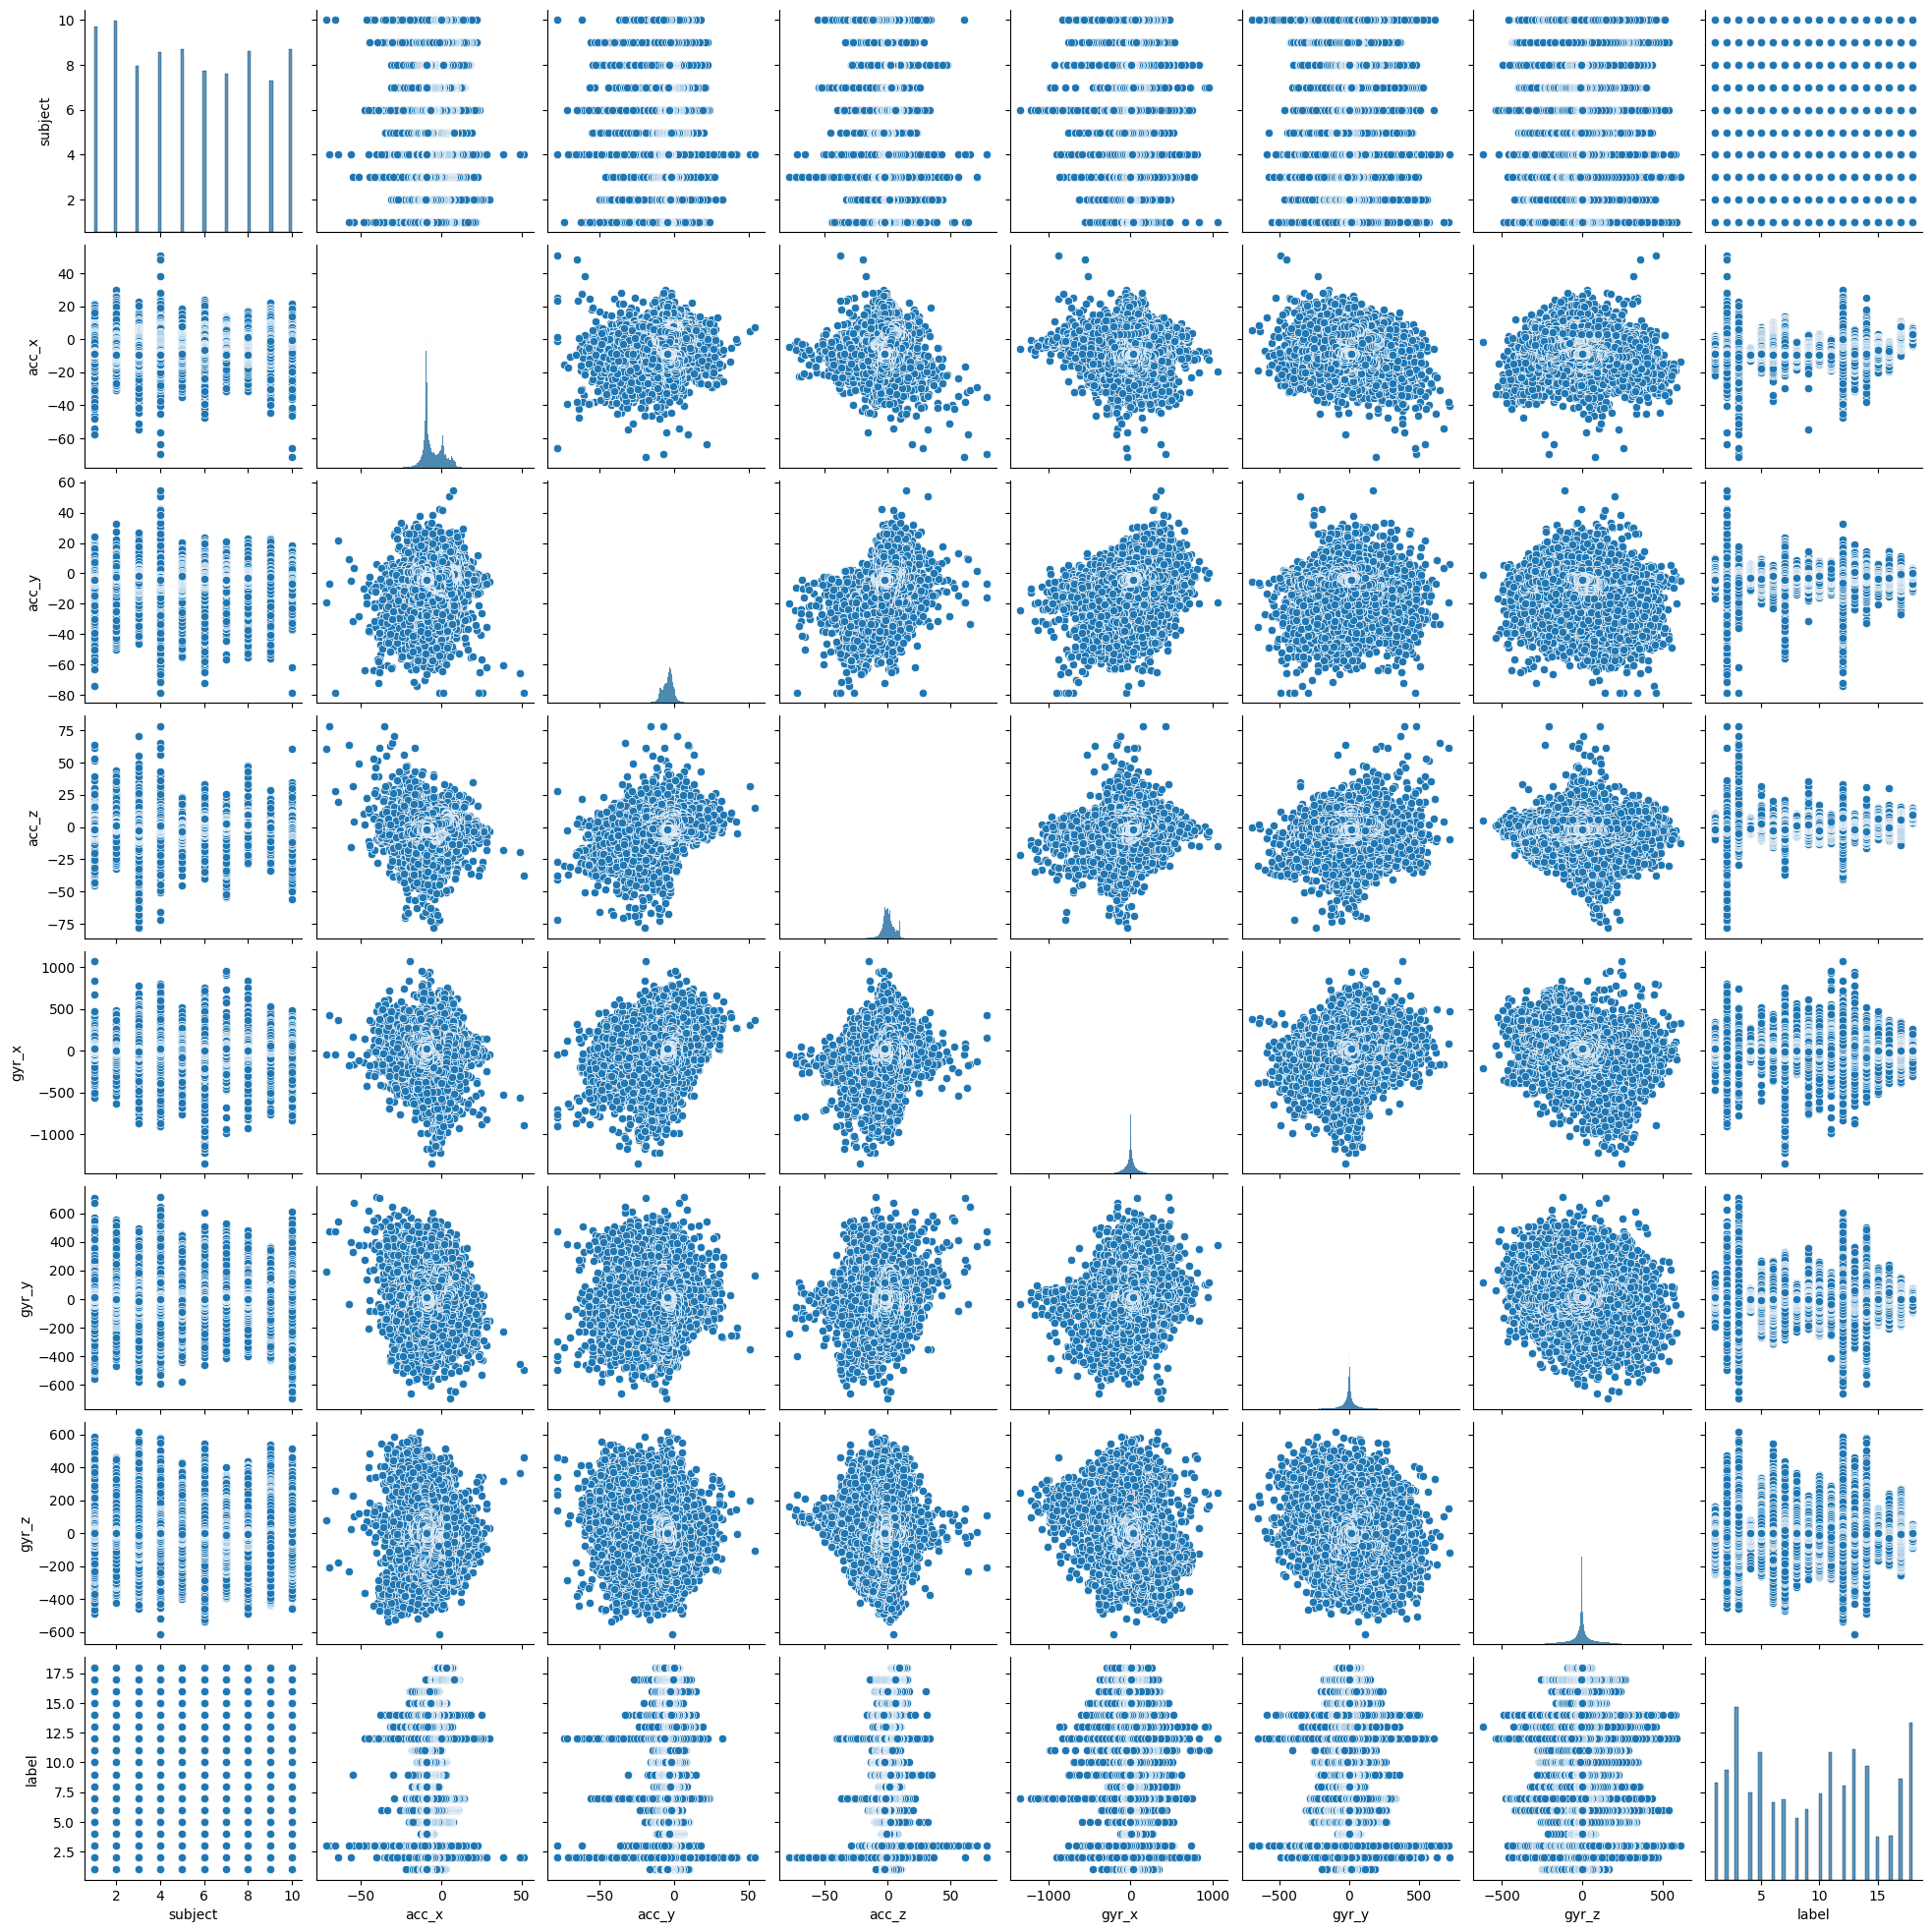

In [12]:
# Create Pair Plots
sns.pairplot(df)
plt.show()

# Data Preprocessing

## Handling Missing Values:
- Imputation techniques (e.g., mean imputation, interpolation) can be used to fill missing data points based on the available data.
  - We prefer the interpolation because these time series data points are related in some way.
- Removing segments of data where a high percentage of values are missing.


In [13]:
# Infer data types to avoid object dtype issues
df = df.infer_objects(copy=False)

# Fill missing data points based on the available data by interpolation
df.interpolate(method='linear', inplace=True)

<ipython-input-13-62c941af835c>:5: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [14]:
# Removing segments of data where a high percentage of values are missing
threshold = 0.5
missing_percentage = df.isnull().sum(axis=1) / df.shape[1]
df[missing_percentage < threshold]

subject     acc_x     acc_y     acc_z      gyr_x      gyr_y  \
0             6 -8.544770 -1.801795 -1.191626  22.120001  43.750000   
1             6 -8.183454 -1.741975 -1.423729  29.680000  40.950001   
2             6 -7.862815 -1.978864 -0.899701  31.850000  35.910000   
3             6 -7.278966 -2.471786 -0.200997  10.920000  35.910000   
4             6 -7.121039 -2.285146 -0.177069 -44.590000  45.430000   
...         ...       ...       ...       ...        ...        ...   
321191        1 -8.889337 -4.228118 -2.215754  28.559999   7.770000   
321192        1 -8.908479 -4.237689 -2.258825  28.840000   8.540000   
321193        1 -8.944371 -4.185047 -2.246860  28.210001   9.520000   
321194        1 -8.965906 -4.228118 -2.227718  27.650000  10.640000   
321195        1 -8.977871 -4.230510 -2.237289  27.650000  12.320000   

            gyr_z  label              action  
0       47.040001     15            sit down  
1       46.410000     15            sit down  
2       44.450001     15            sit down  
3       37.380001     15            sit down  
4       23.450001     15            sit down  
...           ...    ...                 ...  
321191  14.000000      1  one-hand handshake  
321192  11.900000      1  one-hand handshake  
321193   8.750000      1  one-hand handshake  
321194   5.320000      1  one-hand handshake  
321195   1.890000      1  one-hand handshake  

[321196 rows x 9 columns]

In [15]:
(df == 0).sum()

subject    0
acc_x      0
acc_y      0
acc_z      0
gyr_x      0
gyr_y      0
gyr_z      0
label      0
action     0
dtype: int64

In [16]:
df.isnull().sum()

subject    0
acc_x      0
acc_y      0
acc_z      0
gyr_x      0
gyr_y      0
gyr_z      0
label      0
action     0
dtype: int64

## Noise Reduction and Normalization:
- Applying filters (e.g., low-pass filters) to smooth out noise in sensor data.
- Normalizing data to have a consistent scale across different sensors using techniques like min-max scaling or Z-score normalization.

In [17]:
def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)

    return y

In [18]:
fs = 20  # Frequency
cutoff = 5  # Cutoff frequency for the low-pass filter

# Smooth out noise in sensor data
for col in ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']:
    df[col] = low_pass_filter(df[col], cutoff, fs)

In [19]:
scaler = MinMaxScaler()

# Normalizing data
df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']] = scaler.fit_transform(
    df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']]
)

In [20]:
df

subject     acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z  \
0             6  0.500899  0.565029  0.638062  0.579736  0.524037  0.495507   
1             6  0.505245  0.565917  0.636469  0.583824  0.521074  0.494632   
2             6  0.510095  0.563225  0.640587  0.583963  0.518424  0.493085   
3             6  0.515649  0.559314  0.646978  0.574142  0.519831  0.487723   
4             6  0.520428  0.560420  0.646993  0.550721  0.525241  0.474238   
...         ...       ...       ...       ...       ...       ...       ...   
321191        1  0.496477  0.544312  0.628470  0.582579  0.499243  0.466054   
321192        1  0.496244  0.544376  0.628547  0.582710  0.499830  0.464158   
321193        1  0.495883  0.544479  0.628550  0.582414  0.500430  0.461397   
321194        1  0.495561  0.544463  0.628551  0.582180  0.501285  0.458321   
321195        1  0.495408  0.544300  0.628582  0.582177  0.502402  0.455260   

        label              action  
0          15            sit down  
1          15            sit down  
2          15            sit down  
3          15            sit down  
4          15            sit down  
...       ...                 ...  
321191      1  one-hand handshake  
321192      1  one-hand handshake  
321193      1  one-hand handshake  
321194      1  one-hand handshake  
321195      1  one-hand handshake  

[321196 rows x 9 columns]

## Data Segmentation:
- Segmenting the data into fixed-size windows with or without overlap (e.g., 5-second windows with 50% overlap) is common in time-series analysis to extract features consistently.
  - We segment the data with overlap (1-second windows with 50% overlap) to keep the dataset large enough to train and test the model.

In [21]:
window_size = 20  # 1-second window * 20 frequency
overlap = 0.5  # 50% overlap

segments = []
labels = []

for i in range(0, len(df) - window_size + 1, int(window_size * (1 - overlap))):
    # Extract the window
    window = df.iloc[i: i + window_size]

    # Append the window to the list of segments
    segments.append(window[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)

    # Take the most frequent label in the window
    labels.append(window['label'].mode()[0])

segments = np.array(segments)
labels = np.array(labels)

In [22]:
segments.shape, labels.shape

((32118, 20, 6), (32118,))

# Feature Engineering
- Extraction of time-domain and frequency-domain features from sensor data.
- Feature selection techniques to identify the most 10 informative features.

In [23]:
def extract_time_domain_features(segment):
    features = []
    feature_names = []

    for axis in range(segment.shape[1]):
        axis_data = segment[:, axis]
        features.append(np.mean(axis_data))  # Mean
        feature_names.append(f'mean_{axis}')
        features.append(np.std(axis_data))  # Standard deviation
        feature_names.append(f'std_{axis}')
        features.append(np.min(axis_data))  # Minimum
        feature_names.append(f'min_{axis}')
        features.append(np.max(axis_data))  # Maximum
        feature_names.append(f'max_{axis}')

    return features, feature_names

all_features = []
all_feature_names = []
for segment in segments:
    features, feature_names = extract_time_domain_features(segment)
    all_features.append(features)
    all_feature_names = feature_names

time_domain_features = np.array(all_features)
time_domain_features_df = pd.DataFrame(time_domain_features, columns=all_feature_names)

In [24]:
def spectral_entropy(data):
    psd = np.abs(fft(data))**2
    psd_norm = psd / psd.sum()

    return entropy(psd_norm)

def extract_frequency_domain_features(segment):
    features = []
    feature_names = []

    for axis in range(segment.shape[1]):
        axis_data = segment[:, axis]
        fft_coeffs = np.abs(fft(axis_data))  # Fourier transform
        features.append(np.mean(fft_coeffs))  # Mean frequency
        feature_names.append(f'mean_freq_{axis}')
        features.append(np.std(fft_coeffs))  # Standard deviation
        feature_names.append(f'std_freq_{axis}')
        features.append(spectral_entropy(axis_data))  # Spectral entropy
        feature_names.append(f'spectral_entropy_{axis}')
        features.append(np.sum(fft_coeffs ** 2) / len(fft_coeffs))  # Spectral energy
        feature_names.append(f'spectral_energy_{axis}')

    return features, feature_names

all_features = []
all_feature_names = []
for segment in segments:
    features, feature_names = extract_frequency_domain_features(segment)
    all_features.append(features)
    all_feature_names = feature_names

frequency_domain_features = np.array(all_features)
frequency_domain_features_df = pd.DataFrame(frequency_domain_features, columns=all_feature_names)

In [25]:
# Combine features
all_features_df = pd.concat([time_domain_features_df, frequency_domain_features_df], axis=1)
all_features_df.head(5)

mean_0     std_0     min_0     max_0    mean_1     std_1     min_1  \
0  0.497863  0.023902  0.443303  0.522173  0.565071  0.012786  0.537993   
1  0.478289  0.018798  0.443303  0.508237  0.554106  0.025952  0.504462   
2  0.492376  0.023601  0.454757  0.550033  0.527684  0.022536  0.497258   
3  0.527963  0.024100  0.487835  0.553770  0.527354  0.022099  0.497258   
4  0.547957  0.003302  0.542125  0.553806  0.529580  0.019750  0.497439   

      max_1    mean_2     std_2  ...  spectral_entropy_3  spectral_energy_3  \
0  0.588702  0.624093  0.013023  ...            0.109058           7.437677   
1  0.590637  0.636971  0.027923  ...            0.069689           7.868347   
2  0.590637  0.666182  0.017363  ...            0.017198           6.669259   
3  0.568646  0.686133  0.014547  ...            0.013344           6.615220   
4  0.568646  0.697063  0.006511  ...            0.012394           6.573483   

   mean_freq_4  std_freq_4  spectral_entropy_4  spectral_energy_4  \
0     0.573340    2.161295            0.016613           4.999913   
1     0.549875    2.026675            0.024687           4.409772   
2     0.511754    1.928009            0.021106           3.979110   
3     0.520512    1.954403            0.026598           4.090626   
4     0.543599    2.057120            0.015432           4.527241   

   mean_freq_5  std_freq_5  spectral_entropy_5  spectral_energy_5  
0     0.536401    1.886282            0.044019           3.845786  
1     0.485039    1.711424            0.053954           3.164235  
2     0.489860    1.713671            0.057699           3.176632  
3     0.470278    1.850781            0.010594           3.646552  
4     0.490342    1.931886            0.010629           3.972621  

[5 rows x 48 columns]

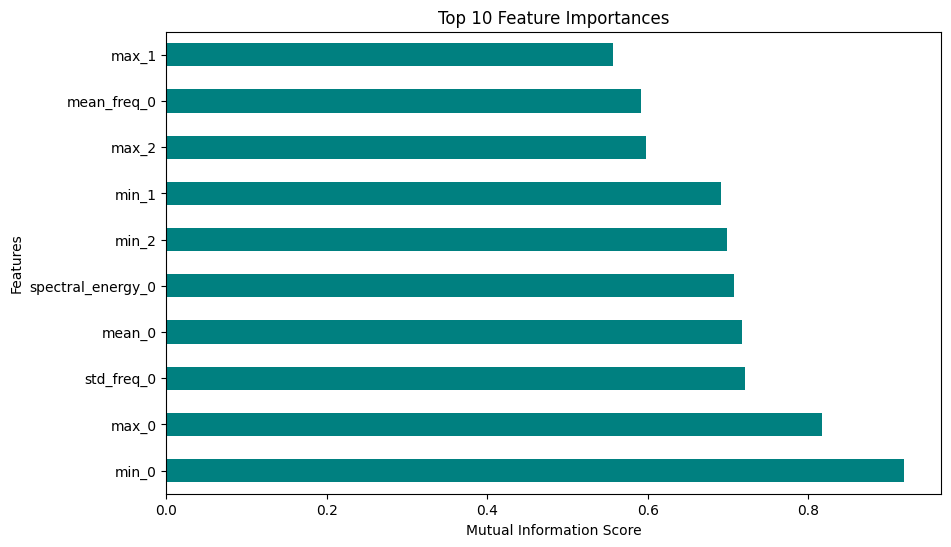

In [26]:
# Calculate mutual information
importances = mutual_info_classif(all_features_df, labels)

# Plot feature importances
feat_importances = pd.Series(importances, index=all_features_df.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Top 10 Feature Importances') # Added title for clarity
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

# Model Development
- Explore and compare different machine learning models, including decision trees, KNN (K- Nearest Neighbors), support vector machines, random forests and naïve bayes.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.25, random_state=42)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24088, 20, 6), (8030, 20, 6), (24088,), (8030,))

In [29]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [30]:
X_train_flat.shape, X_test_flat.shape, y_train.shape, y_test.shape

((24088, 120), (8030, 120), (24088,), (8030,))

## Decision Trees

In [31]:
# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train_flat, y_train)

DecisionTreeClassifier(random_state=42)

## K-Nearest Neighbors

In [32]:
# Initialize the KNN (K- Nearest Neighbors) classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_flat, y_train)

KNeighborsClassifier()

## Support Vector Machines

In [33]:
# Initialize the Support Vector Machines classifier
svm = SVC(kernel='linear', random_state=42)

# Train the model
svm.fit(X_train_flat, y_train)

SVC(kernel='linear', random_state=42)

## Random Forest

In [34]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

## Naïve Bayes

In [35]:
# Initialize the Gaussian Naive Bayes classifier
nb = GaussianNB()

# Train the model
nb.fit(X_train_flat, y_train)

GaussianNB()

# Advanced Model Exploration
- Explore the advance models like ANN, CNN and RNN.

In [36]:
# Set input & output dimensions
num_samples, num_time_periods, num_sensors = segments.shape
num_classes = df['action'].nunique()
actions = df['action'].unique()
print(list(actions))

['sit down', 'drink water', 'hand in hand', 'one-hand handshake', 'keystroke', 'high five', 'bisous/ fact to face', 'stand up', 'kiss on the forehead', 'pass on things', 'walk', 'down the stars', 'bow', 'kiss on the hand', 'up the stairs', 'run', 'hug', 'two-hand handshake']


In [37]:
# One-hot encode the labels
y_train_one_hot = to_categorical(y_train - 1, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test - 1, num_classes=num_classes)

In [38]:
X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

((24088, 20, 6), (8030, 20, 6), (24088, 18), (8030, 18))

## ANN

In [39]:
# Define the ANN model
ann = Sequential()
ann.add(Input(shape=(num_time_periods, num_sensors)))
ann.add(Flatten())
ann.add(Dense(64, activation='relu'))
ann.add(Dropout(0.5))
ann.add(Dense(32, activation='relu'))
ann.add(Dropout(0.5))
ann.add(Dense(num_classes, activation='softmax'))

In [40]:
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           7,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,418 (40.70 KB)

 Trainable params: 10,418 (40.70 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Compile the model
ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
ann_history = ann.fit(X_train, y_train_one_hot, epochs = 50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0854 - loss: 2.8723 - val_accuracy: 0.1164 - val_loss: 2.7625
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1326 - loss: 2.7314 - val_accuracy: 0.1733 - val_loss: 2.4985
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1559 - loss: 2.5882 - val_accuracy: 0.1694 - val_loss: 2.4390
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1669 - loss: 2.5373 - val_accuracy: 0.1696 - val_loss: 2.4438
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1670 - loss: 2.5252 - val_accuracy: 0.1683 - val_loss: 2.4072
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1654 - loss: 2.5122 - val_accuracy: 0.1677 - val_loss: 2.4082
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1657 - loss: 2.5008 - val_accuracy: 0.1723 - val_loss: 2.3911
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1762 - loss: 2.4790 - val_accuracy: 0.

## CNN

In [42]:
# Define the CNN model
cnn = Sequential()
cnn.add(Input(shape=(num_time_periods, num_sensors)))
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(num_classes, activation='softmax'))

In [43]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 18, 32)              │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 16, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          25,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 18)                  │           1,818 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,230 (121.99 KB)

 Trainable params: 31,230 (121.99 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Compile the model
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
cnn_history = cnn.fit(X_train, y_train_one_hot, epochs = 50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1641 - loss: 2.5944 - val_accuracy: 0.3369 - val_loss: 2.1417
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3506 - loss: 1.9677 - val_accuracy: 0.4328 - val_loss: 1.8299
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4224 - loss: 1.7714 - val_accuracy: 0.4751 - val_loss: 1.7602
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4605 - loss: 1.6664 - val_accuracy: 0.4689 - val_loss: 1.6939
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4821 - loss: 1.6087 - val_accuracy: 0.5075 - val_loss: 1.5831
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5060 - loss: 1.5349 - val_accuracy: 0.4950 - val_loss: 1.6168
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5139 - loss: 1.4977 - val_accuracy: 0.5519 - val_loss: 1.4739
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5364 - loss: 1.4507 - val_accuracy: 0.

## RNN

In [45]:
# Define the RNN model
rnn = Sequential()
rnn.add(Input(shape=(num_time_periods, num_sensors)))
rnn.add(GRU(200, return_sequences=True))
rnn.add(Dropout(0.5))
rnn.add(GRU(100, return_sequences=True))
rnn.add(Dropout(0.5))
rnn.add(GRU(50))
rnn.add(Dropout(0.5))
rnn.add(Dense(num_classes, activation='softmax'))

In [46]:
rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 200)             │         124,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 20, 100)             │          90,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │             918 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 239,118 (934.05 KB)

 Trainable params: 239,118 (934.05 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Compile the model
rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
rnn_history = rnn.fit(X_train, y_train_one_hot, epochs = 50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.1257 - loss: 2.7014 - val_accuracy: 0.2688 - val_loss: 2.2373
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2380 - loss: 2.2742 - val_accuracy: 0.3333 - val_loss: 2.0253
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3253 - loss: 2.0108 - val_accuracy: 0.3715 - val_loss: 1.8215
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3982 - loss: 1.8326 - val_accuracy: 0.4682 - val_loss: 1.6235
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4489 - loss: 1.7121 - val_accuracy: 0.4927 - val_loss: 1.5017
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4806 - loss: 1.6278 - val_accuracy: 0.4606 - val_loss: 1.5911
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5005 - loss: 1.5694 - val_accuracy: 0.5457 - val_loss: 1.4041
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5131 - loss: 1.5240 - val_accura

# Evaluation
- Implement 10-fold cross-validation and Leave One Subject Out/ Leave One Episode Out cross-validation to evaluate model performance.
- Use appropriate metrics (accuracy, F1 score, precision, recall) to evaluate model performance.

In [48]:
# Define function to evaluate supervised learning models
def evaluate_supervised_model(model, X_test, y_test, accuracies_list, precisions_list, recalls_list, f1_scores_list):
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracies_list.append(accuracy_score(y_test, y_pred))
    report = classification_report(y_test, y_pred, target_names=actions, output_dict=True, zero_division=0)
    precisions_list.append(report['weighted avg']['precision'])
    recalls_list.append(report['weighted avg']['recall'])
    f1_scores_list.append(report['weighted avg']['f1-score'])

In [49]:
# Define function to evaluate advanced models
def evaluate_advanced_model(model, X_test, y_test, accuracies_list, precisions_list, recalls_list, f1_scores_list):
    # Evaluate the model
    lost, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    accuracies_list.append(accuracy)

    # Make predictions
    y_pred = model.predict(X_test)
    report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),
                                   target_names=actions, output_dict=True, zero_division=0)
    precisions_list.append(report['weighted avg']['precision'])
    recalls_list.append(report['weighted avg']['recall'])
    f1_scores_list.append(report['weighted avg']['f1-score'])

In [50]:
# Implement Leave One Episode Out Cross-validation
groups = df['subject'].iloc[0: len(df) - window_size + 1 : int(window_size * (1 - overlap))]
logo = LeaveOneGroupOut()

# Initialize metrics
metrics = {
    'dt': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'knn': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'svm': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'rf': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'nb': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'ann': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'cnn': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []},
    'rnn': {'accuracies': [], 'precisions': [], 'recalls': [], 'f1_scores': []}
}

for train_index, test_index in logo.split(segments, labels, groups):
    X_train_outer, X_test_outer = segments[train_index], segments[test_index]
    y_train_outer, y_test_outer = labels[train_index], labels[test_index]

    # Implement 10-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    for inner_train_index, inner_test_index in kfold.split(X_train_outer):
        X_train_inner, X_test_inner = X_train_outer[inner_train_index], X_train_outer[inner_test_index]
        y_train_inner, y_test_inner = y_train_outer[inner_train_index], y_train_outer[inner_test_index]

        # Flatten the data for Decision Tree
        X_train_inner_flat = X_train_inner.reshape(X_train_inner.shape[0], -1)
        X_test_inner_flat = X_test_inner.reshape(X_test_inner.shape[0], -1)

        # Decision Tree
        evaluate_supervised_model(
            dt, X_test_inner_flat, y_test_inner,
            metrics['dt']['accuracies'], metrics['dt']['precisions'],
            metrics['dt']['recalls'], metrics['dt']['f1_scores'])

        # K-Nearest Neighbors
        evaluate_supervised_model(
            knn, X_test_inner_flat, y_test_inner,
            metrics['knn']['accuracies'], metrics['knn']['precisions'],
            metrics['knn']['recalls'], metrics['knn']['f1_scores'])

        # Support Vector Machines
        evaluate_supervised_model(
            svm, X_test_inner_flat, y_test_inner,
            metrics['svm']['accuracies'], metrics['svm']['precisions'],
            metrics['svm']['recalls'], metrics['svm']['f1_scores'])

        # Random Forest
        evaluate_supervised_model(
            rf, X_test_inner_flat, y_test_inner,
            metrics['rf']['accuracies'], metrics['rf']['precisions'],
            metrics['rf']['recalls'], metrics['rf']['f1_scores'])

        # Naïve Bayes
        evaluate_supervised_model(
            nb, X_test_inner_flat, y_test_inner,
            metrics['nb']['accuracies'], metrics['nb']['precisions'],
            metrics['nb']['recalls'], metrics['nb']['f1_scores'])

        # One-hot encode the labels
        y_train_inner_onehot = to_categorical(y_train_inner - 1, num_classes=num_classes)
        y_test_inner_onehot = to_categorical(y_test_inner - 1, num_classes=num_classes)

        # ANN
        evaluate_advanced_model(
            ann, X_test_inner, y_test_inner_onehot,
            metrics['ann']['accuracies'], metrics['ann']['precisions'],
            metrics['ann']['recalls'], metrics['ann']['f1_scores'])

        # CNN
        evaluate_advanced_model(
            cnn, X_test_inner, y_test_inner_onehot,
            metrics['cnn']['accuracies'], metrics['cnn']['precisions'],
            metrics['cnn']['recalls'], metrics['cnn']['f1_scores'])

        # RNN
        evaluate_advanced_model(
            rnn, X_test_inner, y_test_inner_onehot,
            metrics['rnn']['accuracies'], metrics['rnn']['precisions'],
            metrics['rnn']['recalls'], metrics['rnn']['f1_scores'])

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━

In [51]:
for model_name, model_metrics in metrics.items():
    print(f"Model: {model_name.upper()}")
    print(f"Accuracy = {np.mean(model_metrics['accuracies']) * 100:.2f}%")
    print(f"Precision = {np.mean(model_metrics['precisions']) * 100:.2f}%")
    print(f"Recall = {np.mean(model_metrics['recalls']) * 100:.2f}%")
    print(f"F1-score = {np.mean(model_metrics['f1_scores']) * 100:.2f}%")
    print()

Model: DT
Accuracy = 88.76%
Precision = 88.83%
Recall = 88.76%
F1-score = 88.76%

Model: KNN
Accuracy = 78.40%
Precision = 79.87%
Recall = 78.40%
F1-score = 78.47%

Model: SVM
Accuracy = 40.07%
Precision = 41.70%
Recall = 40.07%
F1-score = 37.08%

Model: RF
Accuracy = 94.12%
Precision = 94.28%
Recall = 94.12%
F1-score = 94.12%

Model: NB
Accuracy = 46.83%
Precision = 48.96%
Recall = 46.83%
F1-score = 46.00%

Model: ANN
Accuracy = 20.13%
Precision = 11.05%
Recall = 20.13%
F1-score = 11.20%

Model: CNN
Accuracy = 65.12%
Precision = 69.82%
Recall = 65.12%
F1-score = 65.11%

Model: RNN
Accuracy = 74.06%
Precision = 75.05%
Recall = 74.06%
F1-score = 74.17%



In [52]:
models = ['Decision Tree', 'KNN', 'SVM', 'Random Forest', 'Naïve Bayes']
accuracies = [np.mean(metrics['dt']['accuracies']), np.mean(metrics['knn']['accuracies']),
              np.mean(metrics['svm']['accuracies']), np.mean(metrics['rf']['accuracies']),
              np.mean(metrics['nb']['accuracies'])]
precisions = [np.mean(metrics['dt']['precisions']), np.mean(metrics['knn']['precisions']),
              np.mean(metrics['svm']['precisions']), np.mean(metrics['rf']['precisions']),
              np.mean(metrics['nb']['precisions'])]
recalls = [np.mean(metrics['dt']['recalls']), np.mean(metrics['knn']['recalls']),
           np.mean(metrics['svm']['recalls']), np.mean(metrics['rf']['recalls']),
           np.mean(metrics['nb']['recalls'])]
f1_scores = [np.mean(metrics['dt']['f1_scores']), np.mean(metrics['knn']['f1_scores']),
             np.mean(metrics['svm']['f1_scores']), np.mean(metrics['rf']['f1_scores']),
             np.mean(metrics['nb']['f1_scores'])]

# Create grouped bar chart
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=models, y=accuracies, text=np.round(accuracies, 2), textposition='outside'),
    go.Bar(name='Precision', x=models, y=precisions, text=np.round(precisions, 2), textposition='outside'),
    go.Bar(name='Recall', x=models, y=recalls, text=np.round(recalls, 2), textposition='outside'),
    go.Bar(name='F1-Score', x=models, y=f1_scores, text=np.round(f1_scores, 2), textposition='outside')
])

# Update layout
fig.update_layout(barmode='group', title_text='Performance Comparison On Different Models', yaxis=dict(
        title='Scores'), xaxis=dict(title='Models'))

# Show the figure
fig.show()

In [53]:
models = ['ANN', 'CNN', 'RNN']
accuracies = [np.mean(metrics['ann']['accuracies']), np.mean(metrics['cnn']['accuracies']),
              np.mean(metrics['rnn']['accuracies'])]
precisions = [np.mean(metrics['ann']['precisions']), np.mean(metrics['cnn']['precisions']),
              np.mean(metrics['rnn']['precisions'])]
recalls = [np.mean(metrics['ann']['recalls']), np.mean(metrics['cnn']['recalls']),
           np.mean(metrics['rnn']['recalls'])]
f1_scores = [np.mean(metrics['ann']['f1_scores']), np.mean(metrics['cnn']['f1_scores']),
             np.mean(metrics['rnn']['f1_scores'])]

# Create grouped bar chart
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=models, y=accuracies, text=np.round(accuracies, 2), textposition='outside'),
    go.Bar(name='Precision', x=models, y=precisions, text=np.round(precisions, 2), textposition='outside'),
    go.Bar(name='Recall', x=models, y=recalls, text=np.round(recalls, 2), textposition='outside'),
    go.Bar(name='F1-Score', x=models, y=f1_scores, text=np.round(f1_scores, 2), textposition='outside')
])

# Update layout
fig.update_layout(barmode='group', title_text='Performance Comparison On Different Models', yaxis=dict(
        title='Scores'), xaxis=dict(title='Models'))

# Show the figure
fig.show()

### The Decision Tree model has the highest performance, with accuracy and other values of nearly 90%. Therefore, it is the most effective model for this dataset. The reason is that the inherent ability of decision trees to handle complex patterns and non-linear relationships in the data.
### The Naive Bayes model performs worse, with an accuracy and all other values around 47%. The reason is that it kind of struggles with the dataset's complexity, and possibly, the assumptions of feature independence are not met.
### The ANN model shows the poorest performance, with an accuracy of 20% and a significantly low precision of 11%. It indicates high misclassification rates and an inability to learn effectively from the provided features.
### The CNN and RNN models perform well, with CNN achieving an accuracy of 65% and RNN at 74%. Their other values are balanced but indicate that while capturing some patterns in the data, they are less effective than the Decision Tree model.

# Conclusion

### In this analysis of the SoDA dataset, we evaluated many machine learning models to determine their effectiveness in recognizing social distancing actions based on sensor data. This information in performance highlights the importance of model selection and feature engineering tailored to the specific characteristics of the dataset.
### For potential improvements and future research directions, there are several approaches that we can consider:
### 1. Hyperparameter Tuning: Systematically tuning hyperparameters using techniques such as grid or random search can help find the optimal settings for each model, potentially improving its performance.
### 2. Data Augmentation: The importance of increasing the dataset size through data augmentation techniques cannot be overstated. It is a crucial step that could help train more robust models, particularly for deep learning approaches like CNNs and RNNs, providing a sense of reassurance about the quality of the models.
### 3. Advanced Neural Network Architectures: Exploring more advanced neural network architectures, such as Long Short-Term Memory (LSTM) networks or attention-based models, might improve the RNN model's ability to capture temporal dependencies in the data.